<a href="https://colab.research.google.com/github/kashish2610/Pytorch/blob/main/D10_ANN_HYPERPARA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)

In [ ]:
# check availability of gpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

using cuda


In [ ]:
df=pd.read_csv("/content/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


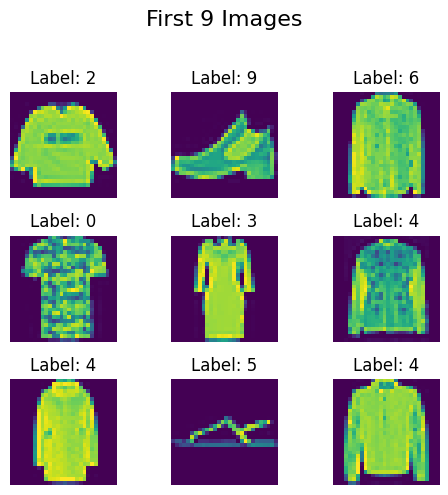

In [ ]:

# Create a 4x4 grid of images
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
fig.suptitle("First 9 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [ ]:
# create CustomDataset Class
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):

    return len(self.features)

  def __getitem__(self, index):

    return self.features[index], self.labels[index]



In [ ]:
#create tr_dataset obj
tr_ds=CustomDataset(X_train,y_train)

In [ ]:
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_dim,output_dim,num_hidden_layers,neurons_per_layer,dp_rate ):

    super().__init__()
    layers=[]
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dp_rate))
      input_dim=neurons_per_layer
    layers.append(nn.Linear(input_dim,output_dim))
    self.model=nn.Sequential(*layers)
  def forward(self,x):
    return self.model(x)

In [ ]:
# Objective Function
def obj(trial):

  # nxt trail hypreparameterval from search
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  ep= trial.suggest_int("epochs",10,50,step=10)
  lr=trial.suggest_float("lr",1e-5,1e-1,log=True)
  dp_rate=trial.suggest_float("dp_rate",0.0,0.5,step=0.1)
  batch_size=trial.suggest_categorical("batch_size",[16,32,64,128])
  opt=trial.suggest_categorical("optimizer",["adam","sgd","RMSprop"])
  wgt_decay=trial.suggest_float("wgt_decay",1e-5,1e-1,log=True)



  # create train and test loader
  train_loader = DataLoader(tr_ds, batch_size=64, shuffle=True,pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
  # model init
  input_dim=X_train.shape[1]
  output_dim=10
  model=MyNN(input_dim,output_dim,num_hidden_layers,neurons_per_layer,dp_rate)
  model.to(device)

  # optimizer selection
  # loss function
  criterion = nn.CrossEntropyLoss()
  # optimizer

  if opt=="adam":
    optimizer = optim.Adam( model.parameters(), lr=lr,weight_decay=wgt_decay)
  elif opt=="sgd":
    optimizer = optim.SGD( model.parameters(), lr=lr, weight_decay=wgt_decay)
  else:
    optimizer = optim.RMSprop( model.parameters(), lr=lr, weight_decay=wgt_decay)
  # training loop
  for epoch in range(ep):
    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

    # evaluation
    model.eval()
    total=0
    correct=0
    with torch.no_grad():

      for batch_features, batch_labels in test_loader:
        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

      accuracy = correct/total

  return accuracy


In [ ]:
!pip install optuna

In [ ]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-10-31 21:09:20,183] A new study created in memory with name: no-name-12d49f27-d501-447a-8efd-dd625169f124


In [ ]:

study.optimize(obj, n_trials=10)

[I 2025-10-31 21:10:11,877] Trial 0 finished with value: 0.09575 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 24, 'epochs': 20, 'lr': 0.026213842048212792, 'dp_rate': 0.4, 'batch_size': 32, 'optimizer': 'adam', 'wgt_decay': 0.05916257188374123}. Best is trial 0 with value: 0.09575.
[I 2025-10-31 21:11:28,836] Trial 1 finished with value: 0.75225 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 104, 'epochs': 50, 'lr': 1.3927813615484185e-05, 'dp_rate': 0.0, 'batch_size': 16, 'optimizer': 'sgd', 'wgt_decay': 3.1729584492924174e-05}. Best is trial 1 with value: 0.75225.
[I 2025-10-31 21:11:51,285] Trial 2 finished with value: 0.85625 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 96, 'epochs': 10, 'lr': 2.1531999210273443e-05, 'dp_rate': 0.5, 'batch_size': 128, 'optimizer': 'RMSprop', 'wgt_decay': 0.001440813703714416}. Best is trial 2 with value: 0.85625.
[I 2025-10-31 21:14:01,961] Trial 3 finished with value: 0.8846666666666667 and paramete

In [ ]:
study.best_value


0.8846666666666667

In [ ]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 64,
 'epochs': 50,
 'lr': 0.010249102519687773,
 'dp_rate': 0.4,
 'batch_size': 16,
 'optimizer': 'adam',
 'wgt_decay': 6.358869745072986e-05}